# Sanity Checks Before Launching

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
import numpy as np
from pyrl.tasks.pacman.game_mdp import *
from pyrl.tasks.pacman.ghostAgents import *
import pyrl.tasks.pacman.graphicsDisplay as graphicsDisplay
import pyrl.tasks.pacman.textDisplay as textDisplay
from pyrl.utils import Timer
from pyrl.prob import choice
import pyrl.agents.arch as arch
from pyrl.algorithms.valueiter import DeepQlearn
from pyrl.agents.agent import DQN
from pyrl.evaluate import reward_stochastic
import theano
import theano.tensor as T

In [5]:
_layout = layout.getLayout('pyrl/tasks/pacman/layouts/smallGrid.lay')
ghostType = DirectionalGhost
agents = [ghostType( i+1 ) for i in range(2)]
#display = graphicsDisplay.PacmanGraphics(zoom=1.0, frameTime = 0.1)
# display = textDisplay.PacmanGraphics()
display = textDisplay.NullGraphics()



In [68]:
task = PacmanTask(_layout, agents, display, state_repr='stack')

Randomly play the game and test the throughput of the MDP.

In [69]:
with Timer("random-play"):
    scores = []
    for it in range(1000):
        overall_reward = 0.
        if not task.is_end():
            actions = task.valid_actions
            action = choice(actions, 1)[0]
            reward = task.step(action)
            overall_reward += reward
        else:
            sys.stdout.flush()
            _layout = layout.getLayout('pyrl/tasks/pacman/layouts/smallGrid.lay')
            ghostType = DirectionalGhost
            agents = [ghostType( i+1 ) for i in range(2)]
            #display = graphicsDisplay.PacmanGraphics(zoom=1.0, frameTime = 0.1)
            # display = textDisplay.PacmanGraphics()
            display = textDisplay.NullGraphics()
            task = PacmanTask(_layout, agents, display)
            
        
            

[random-play] Start
[random-play] Elapsed: 0.464299201965


In [70]:
input_dim = task.state_shape

def two_layer(states):
    state_vecs = states.flatten(2)
    return arch.two_layer(state_vecs, np.prod(task.state_shape), 128, task.num_actions)
    
    

In [71]:
dqn = DQN(task, arch_func=two_layer, state_type=T.tensor4)

In [72]:
learner = DeepQlearn(dqn, gamma=0.95, lr=1e-3, memory_size = 100, epsilon=0.5)

In [67]:
scores = []
for it in range(100):
    learner.run(task, num_episodes = 100)
    score = reward_stochastic(dqn, task, gamma=0.95, num_trials=10, tol=1e-4)
    scores.append(score)
    print 'it', it, 'score', scores[-1]
plt.plot(scores)

it 0 score -507.6
it 1 score -507.2
it 2 score -508.8
it 3 score -507.6
it 4 score -508.4
it 5 score -507.6
it 6 score -507.8
it 7 score -506.8
it 8 score -507.2
it 9 score -508.2
it 10 score -508.0
it 11 score -508.0
it 12 score -507.8
it 13 score -507.0
it 14 score -510.8
it 15 score -507.0
it 16 score -508.0
it 17 score -507.2
it 18 score -509.5
it 19 score -507.0
it 20 score -508.8
it 21 score -512.0
it 22 score -507.2
it 23 score -508.6
it 24 score -511.6
it 25 score -508.6
it 26 score -513.4
it 27 score -513.4
it 28 score -514.4
it 29 score -512.0
it 30 score -509.0
it 31 score -513.2
it 32 score -512.3
it 33 score -513.1
it 34 score -515.9
it 35 score -513.4
it 36 score -515.8
it 37 score -513.2
it 38 score -516.4
it 39 score -518.7
it 40 score -514.8
it 41 score -516.6
it 42 score -508.4
it 43 score -508.0
it 44 score -515.3
it 45 score -516.5
it 46 score -508.3
it 47 score -508.5
it 48 score -508.2
it 49 score -508.1
it 50 score -509.3
it 51 score -509.4
it 52 score -508.0
it 

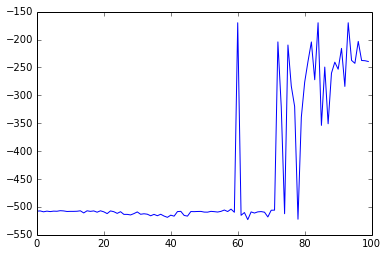

In [72]:
plt.plot(scores)

## ConvNet

[iteration 0] Start
score -507.2
[iteration 0] Elapsed: 0.684231996536
[iteration 1] Start
score -508.0
[iteration 1] Elapsed: 0.747086048126


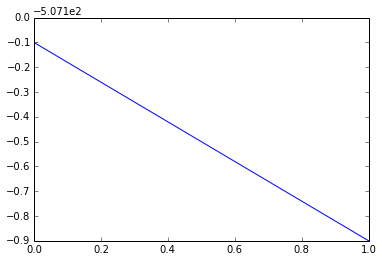

In [73]:
from pyrl.layers import Conv, FullyConnected
import cPickle as pickle
state_shape = task.state_shape
def conv_net(states):
    conv1 = Conv(state_shape[0], output_dim=32, filter_size=(2,2), pool_size=(2,2), activation='relu')
    h1 = conv1(states)
    h1_dim = int((state_shape[1]-2+1)/2) * int((state_shape[2]-2+1)/2) * 32
    h1 = h1.flatten(2)
    fc1 = FullyConnected(input_dim=h1_dim, output_dim=128, activation='relu')
    h2 = fc1(h1)
    linear_layer = FullyConnected(input_dim=128, output_dim=task.num_actions, activation=None)
    output = linear_layer(h2)
    return (output, {
        'conv1': conv1,
        'fc1': fc1 
    })
dqn = DQN(task, arch_func=conv_net, state_type=T.tensor4)
learner = DeepQlearn(dqn, gamma=0.95, lr=1e-3, memory_size = 100, epsilon=0.5)
scores = []
for it in range(2):
    learner.run(task, num_episodes = 100)
    with Timer('iteration %d' % it):
        score = reward_stochastic(dqn, task, gamma=0.95, num_trials=10, tol=1e-4)
        scores.append(score)
        print 'score', scores[-1]
plt.plot(scores)
with open('test.result', 'w') as result:
    pickle.dump({'scores': scores}, result)

# Using Past k frames

In [83]:
task = PacmanTask(_layout, agents, display, state_repr='3-frames')

In [85]:
task.state_shape

(16, 7, 7)

[iteration 0] Start
score -507.0
[iteration 0] Elapsed: 1.1546599865
[iteration 1] Start
score -507.6
[iteration 1] Elapsed: 1.20350694656


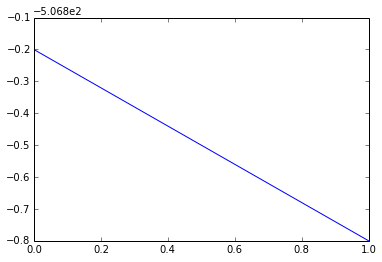

In [86]:
from pyrl.layers import Conv, FullyConnected
import cPickle as pickle
state_shape = task.state_shape
def conv_net(states):
    conv1 = Conv(state_shape[0], output_dim=32, filter_size=(2,2), pool_size=(2,2), activation='relu')
    h1 = conv1(states)
    h1_dim = int((state_shape[1]-2+1)/2) * int((state_shape[2]-2+1)/2) * 32
    h1 = h1.flatten(2)
    fc1 = FullyConnected(input_dim=h1_dim, output_dim=128, activation='relu')
    h2 = fc1(h1)
    linear_layer = FullyConnected(input_dim=128, output_dim=task.num_actions, activation=None)
    output = linear_layer(h2)
    return (output, {
        'conv1': conv1,
        'fc1': fc1 
    })
dqn = DQN(task, arch_func=conv_net, state_type=T.tensor4)
learner = DeepQlearn(dqn, gamma=0.95, lr=1e-3, memory_size = 100, epsilon=0.5)
scores = []
for it in range(2):
    learner.run(task, num_episodes = 100)
    with Timer('iteration %d' % it):
        score = reward_stochastic(dqn, task, gamma=0.95, num_trials=10, tol=1e-4)
        scores.append(score)
        print 'score', scores[-1]
plt.plot(scores)
with open('test.result', 'w') as result:
    pickle.dump({'scores': scores}, result)